In [13]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

## Task 1 bonus Question

### 1. Scaling laws: Scaling Laws Experiment: Analyzing Model Performance Across Compute, Dataset Size, and Model Complexity

The goal here is to analyze how our model performance (test loss) scales with:

- Compute (Training Time & GPU Resources)
- Dataset Size (Number of Storm Events)
- Model Size (Number of Parameters)

#### 1. Dataset Scaling Analysis

- Experiment: Train the model using different proportions of the dataset: 1%, 5%, 10% of the available training data.(As GPU computer units constrians we could not try on larger datasets so i decease the datasize 10 times)

- The total dataset consists of 800 storm events. When selecting more than 100 events, training becomes significantly slower, taking approximately 10 minutes per epoch due to the large image size.
- Image resizing affects both training speed and prediction accuracy:
- 64×64 and 128×128 resolutions train faster but lose fine details.
- 192×192 resolution provides better accuracy but leads to CUDA out-of-memory (OOM) errors when training with the full dataset.
- Metric: Plot test loss vs. dataset size to observe how performance improves with more data.
- Hypothesis: Increasing the dataset size should reduce test loss, but gains diminish beyond a certain threshold.


#### 2. Compute Scaling Analysis

- Experiment: Compare mixed precision (float16) training with full precision (float32) while adjusting hyperparameters like epochs, batch sizes, and GPU runtimes.

- Observation: Mixed precision training significantly reduces memory usage and speeds up training, allowing larger batch sizes and more efficient computations.
- Metric: Plot test loss vs. GPU training time to analyze how performance improves with increasing compute power.
- Hypothesis: More compute should lead to better performance, but the improvement saturates beyond a certain point.


#### 3. Model Scaling Analysis

- Experiment: Train models with varying numbers of Conv3D filters to study the impact of model complexity:

- Reduce filters by half for a smaller model.
- Increase filters by 2× for a larger model.
- Metric: Plot test loss vs. number of parameters to observe the trade-off between model complexity and generalization.
- Hypothesis: Increasing model size should improve accuracy until overfitting occurs, where additional parameters no longer yield performance gains.


In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import h5py
import matplotlib.pyplot as plt
import IPython
import PIL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import io
import shutil
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, ConvLSTM2D, BatchNormalization, Conv3D, Conv3DTranspose,
                                     concatenate, TimeDistributed)
from tensorflow.keras.layers import (Input, Conv3D, BatchNormalization, Conv3DTranspose,
                                     concatenate, Dropout)
from tensorflow.keras.layers import (Input, Conv3D, BatchNormalization, Conv3DTranspose,
                                     concatenate, Dropout)
# file path
h5_file_path = "/content/data/train.h5"
events_csv_path = "/content/data/events.csv"

# load event id and pick vil image type only
events_df = pd.read_csv(events_csv_path)
vil_event_ids = events_df[events_df["img_type"] == "vil"]["id"].dropna().unique().tolist()

# only extract first 100 vil event
event_ids = vil_event_ids[:100]
print("Selected event IDs:", event_ids[:10])

# Load event data
def load_event_data(h5_file_path, event_id):
    with h5py.File(h5_file_path, 'r') as f:
        if event_id in f:
            if isinstance(f[event_id], h5py.Dataset):
                vil_data = f[event_id][:]
            elif 'vil' in f[event_id]:
                vil_data = f[event_id]['vil'][:]
            else:
                raise KeyError(f"Event ID {event_id} does not contain 'vil' data!")
        else:
            raise KeyError(f"Event ID {event_id} not found in the HDF5 file!")
    return vil_data  # Shape: (H, W, T) = (128, 128, 36)

# Normalization
def normalize(data):
    min_val, max_val = data.min(), data.max()
    if max_val - min_val == 0:
        return np.zeros_like(data)
    return (data - min_val) / (max_val - min_val)


def preprocess_event_data(h5_file_path, event_ids, input_frames=12, target_frames=12, image_size=(128, 128)):
    X, y = [], []

    for event_id in event_ids:
        # Load vil data for the specific event
        vil = load_event_data(h5_file_path, event_id)  # Shape: (H, W, T)

        # Resize spatial dimensions (optional)
        resized_vil = np.stack([resize(vil[:, :, t], image_size) for t in range(vil.shape[2])], axis=-1)

        # Normalize vil data to [0, 1]
        vil = normalize(resized_vil)

        # Construct input and target data
        T = vil.shape[2]  # Total number of time steps
        for i in range(max(0, T - (input_frames + target_frames))):
            X.append(vil[:, :, i:i+input_frames])  # Input: first 12 frames
            y.append(vil[:, :, i+input_frames:i+input_frames+target_frames])  # Target: next 12 frames

    # Convert lists to NumPy arrays
    X = np.array(X)  # Shape: (num_samples, H, W, input_frames)
    y = np.array(y)  # Shape: (num_samples, H, W, target_frames)

    # Add channel dimension to X and y
    X = np.expand_dims(X, axis=-1)  # Shape: (num_samples, H, W, input_frames, 1)
    y = np.expand_dims(y, axis=-1)  # Shape: (num_samples, H, W, target_frames, 1)

    return X, y

X, y = preprocess_event_data(h5_file_path, event_ids)

# split train and test data by time order
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Input shape:", X.shape)  # (num_samples, 128, 128, 12, 1)
print("Target shape:", y.shape)  # (num_samples, 128, 128, 12, 1)
# **Define a function to create Deep U-Net models with different sizes**
def deep_unet3d_model(input_shape, num_filters=32):
    """
    Creates a 3D U-Net model where `num_filters` controls the size of the model.

    :param input_shape: (H, W, T, C) - Input shape of the model
    :param num_filters: Base number of filters (default=32). Increase/decrease for model scaling.
    :return: Compiled U-Net model.
    """
    inputs = Input(shape=input_shape)

    # **Encoder**
    conv1 = Conv3D(num_filters, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(num_filters, (3, 3, 3), activation='relu', padding='same')(conv1)
    bn1 = BatchNormalization()(conv1)

    conv2 = Conv3D(num_filters*2, (3, 3, 3), activation='relu', padding='same')(bn1)
    conv2 = Conv3D(num_filters*2, (3, 3, 3), activation='relu', padding='same')(conv2)
    bn2 = BatchNormalization()(conv2)

    conv3 = Conv3D(num_filters*4, (3, 3, 3), activation='relu', padding='same')(bn2)
    conv3 = Conv3D(num_filters*4, (3, 3, 3), activation='relu', padding='same')(conv3)
    bn3 = BatchNormalization()(conv3)

    conv4 = Conv3D(num_filters*8, (3, 3, 3), activation='relu', padding='same')(bn3)
    conv4 = Conv3D(num_filters*8, (3, 3, 3), activation='relu', padding='same')(conv4)
    bn4 = BatchNormalization()(conv4)

    # **Bottleneck**
    bottleneck = Conv3D(num_filters*4, (3, 3, 3), activation='relu', padding='same')(bn4)
    bottleneck = Conv3D(num_filters*4, (3, 3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)

    # **Decoder**
    up1 = Conv3DTranspose(num_filters*8, (3, 3, 3), padding='same', activation="relu")(bottleneck)
    concat1 = concatenate([up1, bn4])
    up1 = Conv3D(num_filters*8, (3, 3, 3), activation='relu', padding='same')(concat1)

    up2 = Conv3DTranspose(num_filters*4, (3, 3, 3), padding='same', activation="relu")(up1)
    concat2 = concatenate([up2, bn3])
    up2 = Conv3D(num_filters*4, (3, 3, 3), activation='relu', padding='same')(concat2)

    up3 = Conv3DTranspose(num_filters*2, (3, 3, 3), padding='same', activation="relu")(up2)
    concat3 = concatenate([up3, bn2])
    up3 = Conv3D(num_filters*2, (3, 3, 3), activation='relu', padding='same')(concat3)

    up4 = Conv3DTranspose(num_filters, (3, 3, 3), padding='same', activation="relu")(up3)
    concat4 = concatenate([up4, bn1])
    up4 = Conv3D(num_filters, (3, 3, 3), activation='relu', padding='same')(concat4)

    # **Final Output**
    outputs = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(up4)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

    return model

# **Scaling Experiments Configuration**
scaling_results = {"Compute Time": [], "Dataset Size": [], "Model Size": [], "Test Loss": []}

dataset_fractions = [0.01, 0.05, 0.01]  # Train on 1%, 5%, 10% data due to computer units constrains i trained in less data
model_sizes = [16, 64]  # Small, Large models

for fraction in dataset_fractions:
    for model_size in model_sizes:
        print(f"Training model with {fraction*100}% data and {model_size} base filters...")

        # **Subsample dataset**
        num_samples = int(fraction * X_train.shape[0])
        X_train_subset, y_train_subset = X_train[:num_samples], y_train[:num_samples]
        X_test_subset, y_test_subset = X_test[:num_samples], y_test[:num_samples]

        # **Create model**
        model = deep_unet3d_model(X_train.shape[1:], num_filters=model_size)

        # **Measure training time**
        start_time = time.time()
        history = model.fit(X_train_subset, y_train_subset, validation_data=(X_test_subset, y_test_subset),
                            epochs=20, batch_size=16, verbose=1,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                       ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2)])
        end_time = time.time()

        # **Evaluate test loss**
        test_loss = model.evaluate(X_test_subset, y_test_subset, verbose=0)[0]
        compute_time = end_time - start_time

        # **Store results**
        scaling_results["Compute Time"].append(compute_time)
        scaling_results["Dataset Size"].append(fraction * len(X_train))
        scaling_results["Model Size"].append(model_size)
        scaling_results["Test Loss"].append(test_loss)


In [ ]:
# **Plot Scaling Laws**
plt.figure(figsize=(15,5))

# Compute vs Loss
plt.subplot(1,3,1)
plt.scatter(scaling_results["Compute Time"], scaling_results["Test Loss"], marker='o')
plt.xlabel("Compute Time (s)")
plt.ylabel("Test Loss")
plt.title("Compute Scaling")

# Dataset Size vs Loss
plt.subplot(1,3,2)
plt.scatter(scaling_results["Dataset Size"], scaling_results["Test Loss"], marker='s')
plt.xlabel("Dataset Size")
plt.ylabel("Test Loss")
plt.title("Dataset Scaling")

# Model Size vs Loss
plt.subplot(1,3,3)
plt.scatter(scaling_results["Model Size"], scaling_results["Test Loss"], marker='^')
plt.xlabel("Model Size (# Filters)")
plt.ylabel("Test Loss")
plt.title("Model Scaling")

plt.show()


Due to limited computer units and memory constrains, i was not able to run this scaling law analysis fully, but the above is the logic of scaling law.

### 2. Explainability: Justifying Predictions

Selected event IDs: ['S778114', 'S767475', 'S771210', 'S782022', 'S769788', 'S782134', 'S780339', 'S780175', 'S769599', 'S780322']
Input shape: (1200, 128, 128, 12, 1)
Target shape: (1200, 128, 128, 12, 1)
Model reloaded and recompiled successfully!


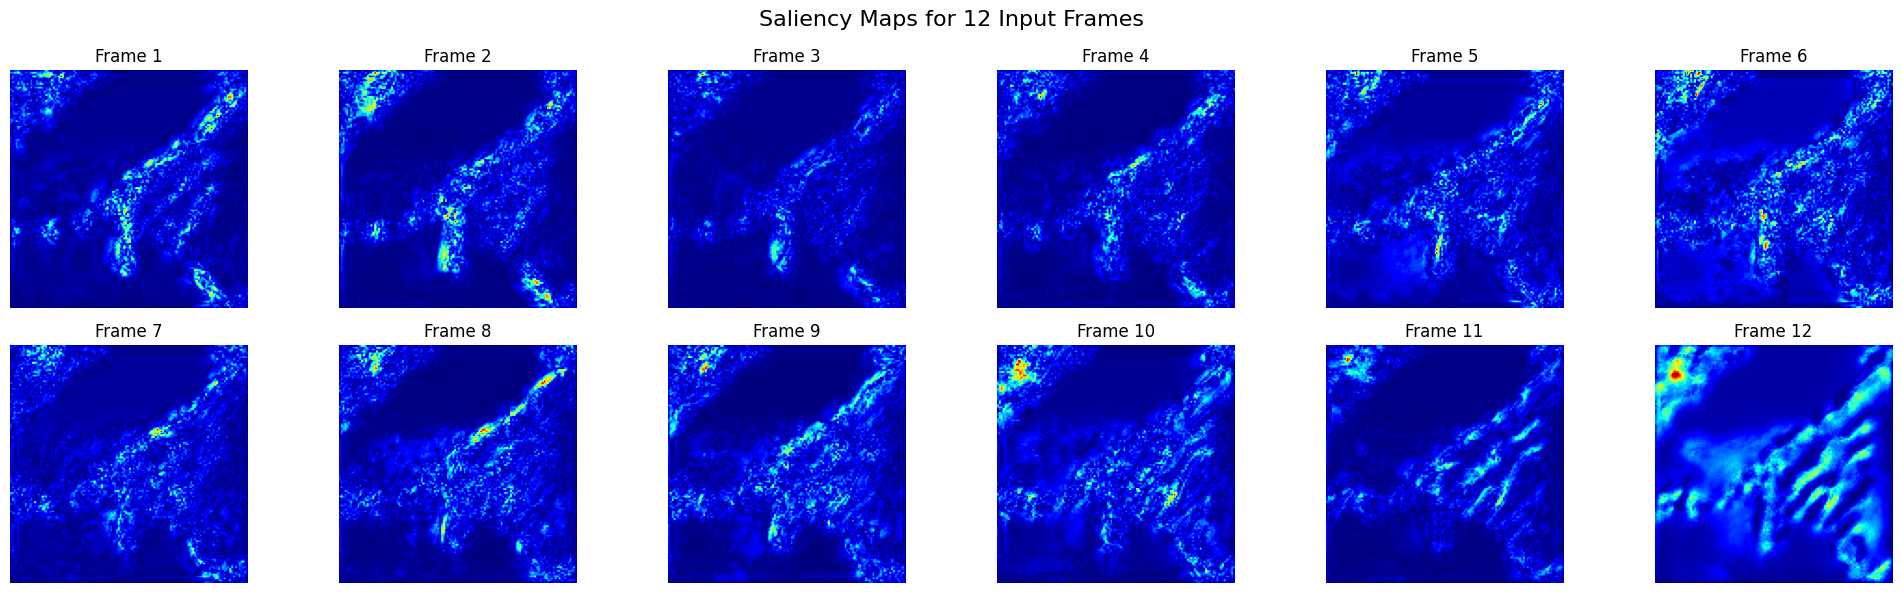

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import h5py
import matplotlib.pyplot as plt
import IPython
import PIL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import io
import shutil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, ConvLSTM2D, BatchNormalization, Conv3D, Conv3DTranspose,
                                     concatenate, TimeDistributed)
from tensorflow.keras.layers import (Input, Conv3D, BatchNormalization, Conv3DTranspose,
                                     concatenate, Dropout)
from tensorflow.keras.layers import (Input, Conv3D, BatchNormalization, Conv3DTranspose,
                                     concatenate, Dropout)
# file path
h5_file_path = "/content/data/train.h5"
events_csv_path = "/content/data/events.csv"

# load event id and pick vil image type only
events_df = pd.read_csv(events_csv_path)
vil_event_ids = events_df[events_df["img_type"] == "vil"]["id"].dropna().unique().tolist()

# only extract first 100 vil event
event_ids = vil_event_ids[:100]
print("Selected event IDs:", event_ids[:10])

# Load event data
def load_event_data(h5_file_path, event_id):
    with h5py.File(h5_file_path, 'r') as f:
        if event_id in f:
            if isinstance(f[event_id], h5py.Dataset):
                vil_data = f[event_id][:]
            elif 'vil' in f[event_id]:
                vil_data = f[event_id]['vil'][:]
            else:
                raise KeyError(f"Event ID {event_id} does not contain 'vil' data!")
        else:
            raise KeyError(f"Event ID {event_id} not found in the HDF5 file!")
    return vil_data  # Shape: (H, W, T) = (128, 128, 36)

# Normalization
def normalize(data):
    min_val, max_val = data.min(), data.max()
    if max_val - min_val == 0:
        return np.zeros_like(data)
    return (data - min_val) / (max_val - min_val)


def preprocess_event_data(h5_file_path, event_ids, input_frames=12, target_frames=12, image_size=(128, 128)):
    X, y = [], []

    for event_id in event_ids:
        # Load vil data for the specific event
        vil = load_event_data(h5_file_path, event_id)  # Shape: (H, W, T)

        # Resize spatial dimensions (optional)
        resized_vil = np.stack([resize(vil[:, :, t], image_size) for t in range(vil.shape[2])], axis=-1)

        # Normalize vil data to [0, 1]
        vil = normalize(resized_vil)

        # Construct input and target data
        T = vil.shape[2]  # Total number of time steps
        for i in range(max(0, T - (input_frames + target_frames))):
            X.append(vil[:, :, i:i+input_frames])  # Input: first 12 frames
            y.append(vil[:, :, i+input_frames:i+input_frames+target_frames])  # Target: next 12 frames

    # Convert lists to NumPy arrays
    X = np.array(X)  # Shape: (num_samples, H, W, input_frames)
    y = np.array(y)  # Shape: (num_samples, H, W, target_frames)

    # Add channel dimension to X and y
    X = np.expand_dims(X, axis=-1)  # Shape: (num_samples, H, W, input_frames, 1)
    y = np.expand_dims(y, axis=-1)  # Shape: (num_samples, H, W, target_frames, 1)

    return X, y

X, y = preprocess_event_data(h5_file_path, event_ids)

# split train and test data by time order
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Input shape:", X.shape)  # (num_samples, 128, 128, 12, 1)
print("Target shape:", y.shape)  # (num_samples, 128, 128, 12, 1)

def deep_unet3d_model(input_shape):
    inputs = Input(shape=input_shape)

    # **Encoder（deeper）**
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    bn1 = BatchNormalization()(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(bn1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    bn2 = BatchNormalization()(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(bn2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    bn3 = BatchNormalization()(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(bn3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    bn4 = BatchNormalization()(conv4)

    # **Bottleneck（deeper）**
    bottleneck = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(bn4)
    bottleneck = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)

    # **Decoder（deeper）**
    up1 = Conv3DTranspose(256, (3, 3, 3), padding='same', activation="relu")(bottleneck)
    concat1 = concatenate([up1, bn4])
    up1 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(concat1)

    up2 = Conv3DTranspose(128, (3, 3, 3), padding='same', activation="relu")(up1)
    concat2 = concatenate([up2, bn3])
    up2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(concat2)

    up3 = Conv3DTranspose(64, (3, 3, 3), padding='same', activation="relu")(up2)
    concat3 = concatenate([up3, bn2])
    up3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(concat3)

    up4 = Conv3DTranspose(32, (3, 3, 3), padding='same', activation="relu")(up3)
    concat4 = concatenate([up4, bn1])
    up4 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(concat4)

    # **Final Output**
    outputs = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(up4)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

    return model


input_shape = (128, 128, 12, 1)
model = deep_unet3d_model(input_shape)

# **Load the trained model**
# Load the trained model without relying on saved metrics
model = load_model("/content/deepunet3d_vil_192_model.h5", compile=False)

# Recompile the model with metrics defined explicitly
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Confirm model is reloaded and recompiled successfully
print("Model reloaded and recompiled successfully!")

# **Select a test sample for saliency map generation**
sample_index = 0  # Change index to visualize different test samples
input_sample = tf.convert_to_tensor(X_test[sample_index:sample_index+1], dtype=tf.float32)  # Shape: (1, 128, 128, 12, 1)

# **Define the Saliency Function**
def compute_saliency_map(model, input_sample):
    """
    Compute the saliency map using gradients of the output with respect to the input.

    :param model: Trained Keras model
    :param input_sample: A single test sample of shape (1, H, W, T, C)
    :return: Saliency maps of shape (H, W, T)
    """
    with tf.GradientTape() as tape:
        tape.watch(input_sample)  # Enable gradient tracking
        predictions = model(input_sample)  # Forward pass

        # Select a specific output frame (e.g., first predicted frame)
        target_output = predictions[0, :, :, 0, 0]  # Shape: (H, W)

    # Compute gradients
    grads = tape.gradient(target_output, input_sample)

    # Take absolute value of gradients (importance)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)  # Reduce across channels

    return saliency_map.numpy()[0]  # Remove batch dimension

# **Compute Saliency Map**
saliency_map = compute_saliency_map(model, input_sample)  # Shape: (128, 128, 12)

# **Visualize Saliency Maps for Different Time Steps**
fig, axes = plt.subplots(2, 6, figsize=(20, 6))

for t in range(12):
    ax = axes[t // 6, t % 6]
    ax.imshow(saliency_map[:, :, t], cmap='jet')  # Heatmap
    ax.set_title(f"Frame {t+1}")
    ax.axis("off")

plt.suptitle("Saliency Maps for 12 Input Frames", fontsize=16)
plt.tight_layout()
plt.show()


## Observation and Analysis of Saliency Map

- The saliency maps highlight the most important regions of the input images that significantly contributed to the model’s forecast.
- Bright yellow regions indicate areas where small changes in input would lead to large changes in the prediction.
- Dark blue regions indicate areas with low importance in decision-making.

1. In several frames, bright spots appear along storm boundaries, meaning the model is focusing on high-intensity areas (e.g., convective storm regions or strong precipitation zones).
This indicates that the model learns to prioritize dynamic weather features, likely recognizing storm cores.

(a) Strong Activations in Storm Regions

In several frames, bright spots appear along storm boundaries, meaning the model is focusing on high-intensity areas (e.g., convective storm regions or strong precipitation zones). This indicates that the model learns to prioritize dynamic weather features, likely recognizing storm cores.

(b) Temporal Consistency

As the frames progress (from Frame 1 to Frame 12), saliency remains concentrated in similar spatial locations, indicating model consistency in tracking storm movement. This is a good sign—it suggests that the model does not randomly shift focus but follows meaningful weather patterns.

(c) Spatial Feature Attention

The model is not uniformly focusing on the entire image, but rather selectively paying attention to high-gradient regions. This suggests that the model relies more on areas with higher contrast and sharp transitions (e.g., storm edges) than on smooth, low-contrast areas.

(d) Decreasing Saliency Over Time

Frames 1 to 8 exhibit strong localized activations, but beyond Frame 10, the activations become more dispersed and lower in intensity.
This suggests that the model has higher confidence in short-term predictions but loses certainty over longer time horizons.

Model Pros and Cons Based on Saliency Maps
Pros:
- Learns to identify storm structures: The model prioritizes storm regions, which is critical for accurate nowcasting.
- Temporal consistency: The saliency remains in consistent regions, meaning the model is effectively tracking weather features over time.
- Strong feature representation: The model focuses on relevant storm boundaries rather than random noise.

Cons:
- Loss of Saliency in Later Frames (Uncertainty)

- The decreasing intensity in later frames suggests prediction confidence weakens over time.

- Potential fix: Introduce attention mechanisms (e.g., Transformer layers) to reinforce long-term dependencies.
